<a href="https://colab.research.google.com/github/GreNinja47/LSTM-Fake-News-Detector-model/blob/main/Fake_news_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

In [ ]:
import tensorflow as tf
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, Embedding, LSTM
from keras.layers.experimental.preprocessing import Rescaling
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense

Importing the datasets

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# consists of 2 datasets
fake_news = pd.read_csv("/content/drive/MyDrive/DS/News_Detection/fake_news.csv")
true_news = pd.read_csv("/content/drive/MyDrive/DS/News_Detection/true_news.csv")

In [ ]:
fake_news.shape, true_news.shape

((23481, 4), (21417, 4))

In [ ]:
fake_news.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
true_news.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
fake_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [ ]:
true_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


<Figure size 3000x3000 with 0 Axes>

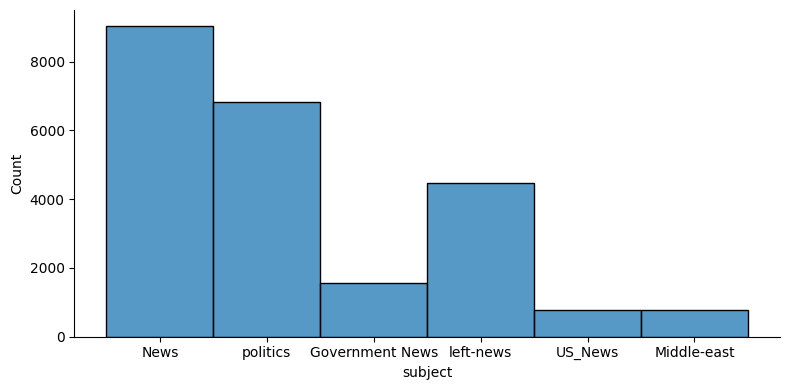

In [ ]:
# Reviewing the subject feature in Fake news
plt.figure(figsize=(30,30))
sns.displot(x='subject', data=fake_news, height=4, aspect=2)
plt.show()

Observation : We see Fake news of the data are more likely to be around the general news and politics

<Figure size 3000x3000 with 0 Axes>

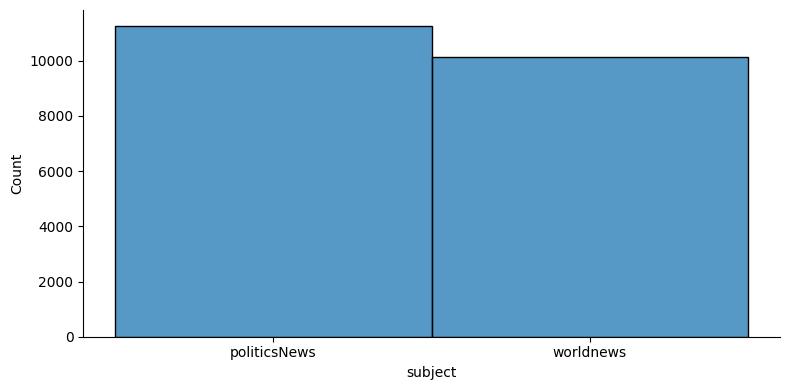

In [ ]:
# Reviewing the subject feature in True news
plt.figure(figsize=(30,30))
sns.displot(x='subject', data=true_news, height=4, aspect=2)
plt.show()

Observation : The Genuine news were on Politics and International news

In [ ]:
# Calculate the median length of text in the true_news dataset
median_length_true_news = true_news['text'].apply(len).median()

# Calculate the median length of text in the fake_news dataset
median_length_fake_news = fake_news['text'].apply(len).median()

print("median length of true news text:", median_length_true_news)
print("median length of fake news text:", median_length_fake_news)

median length of true news text: 2222.0
median length of fake news text: 2166.0


Insight : The real news seem to be conistsing of 56 words on median higher than fake news

In [ ]:
# News from Publishers
print(true_news['text'][0])
print(true_news['text'][1])

WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non-defense “discretionary” spending on programs that support educati

In [ ]:
def clean_text(text):
    try:
        split_text = text.split("-", maxsplit=1)[1]
        clean_text = split_text.split(" -- Source link: ")[0]
        return clean_text
    except IndexError:
        return text  # Return original text if splitting process fails

# Apply the function to the 'text' feature and update 'cleaned_text' column
true_news['clean_text'] = true_news['text'].apply(clean_text)

In [ ]:
true_news['text'][8]

'The following statements\xa0were posted to the verified Twitter accounts of U.S. President Donald Trump, @realDonaldTrump and @POTUS.  The opinions expressed are his own.\xa0Reuters has not edited the statements or confirmed their accuracy.  @realDonaldTrump : - Together, we are MAKING AMERICA GREAT AGAIN! bit.ly/2lnpKaq [1814 EST] - In the East, it could be the COLDEST New Year’s Eve on record. Perhaps we could use a little bit of that good old Global Warming that our Country, but not other countries, was going to pay TRILLIONS OF DOLLARS to protect against. Bundle up! [1901 EST] -- Source link: (bit.ly/2jBh4LU) (bit.ly/2jpEXYR) '

In [ ]:
true_news['clean_text'][8] # tweet

' Together, we are MAKING AMERICA GREAT AGAIN! bit.ly/2lnpKaq [1814 EST] - In the East, it could be the COLDEST New Year’s Eve on record. Perhaps we could use a little bit of that good old Global Warming that our Country, but not other countries, was going to pay TRILLIONS OF DOLLARS to protect against. Bundle up! [1901 EST]'

In [ ]:
true_news.head(5)

,title,text,subject,date,clean_text
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",The head of a conservative Republican faction...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",Transgender people will be allowed for the fi...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",The special counsel investigation of links be...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",Trump campaign adviser George Papadopoulos to...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",President Donald Trump called on the U.S. Pos...


In [ ]:
true_news.notna().sum()

title         21417
text          21417
subject       21417
date          21417
clean_text    21417
dtype: int64

In [ ]:
true_news.drop(['text'],inplace=True,axis=1)

In [ ]:
# There is a text row with space as values in test data

null_index = [index for index, clean_text in enumerate(true_news.clean_text.tolist()) if str(clean_text).strip()==""]

In [ ]:
len(true_news.iloc[null_index])

1

In [ ]:
true_news.iloc[null_index]

,title,subject,date,clean_text
8970,Graphic: Supreme Court roundup,politicsNews,"June 16, 2016",


In [ ]:
true_news.drop(index=8970, inplace=True)

In [ ]:
# There are some text rows with space and commas as values in test data
empty_fake_index = [index for index, text in enumerate(fake_news.text.tolist()) if str(text).strip()==""]

In [ ]:
len(empty_fake_index)

630

In [ ]:
fake_news.iloc[empty_fake_index]

,title,text,subject,date
10923,TAKE OUR POLL: Who Do You Think President Trum...,,politics,"May 10, 2017"
11041,Joe Scarborough BERATES Mika Brzezinski Over “...,,politics,"Apr 26, 2017"
11190,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,politics,"Apr 6, 2017"
11225,MAYOR OF SANCTUARY CITY: Trump Trying To Make ...,,politics,"Apr 2, 2017"
11236,SHOCKER: Public School Turns Computer Lab Into...,,politics,"Apr 1, 2017"
...,...,...,...,...
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015"
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015"
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015"
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015"


In [ ]:
import re

# Assuming 'fake_news' is your DataFrame and 'title' is the column containing titles
fake_news['clean_title'] = fake_news['title'].str.replace(r'\s*\(VIDEO\)\s*', '', regex=True)

In [ ]:
fake_news['clean_title'].iloc[21857]

'ICE PROTECTING OBAMA: WON’T RELEASE NAMES OF CRIMINAL ILLEGALS RELEASED INTO AMERICA'

In [ ]:
# Merging the title and text fields
true_news['updated_text'] = true_news['title'] + " " + true_news['clean_text']
fake_news['updated_text'] = fake_news['clean_title'] + " " + fake_news['text']

In [ ]:
true_news.head(1)

,title,subject,date,clean_text,updated_text
0,"As U.S. budget fight looms, Republicans flip t...",politicsNews,"December 31, 2017",The head of a conservative Republican faction...,"As U.S. budget fight looms, Republicans flip t..."


In [ ]:
true_news.columns, fake_news.columns

(Index(['title', 'subject', 'date', 'clean_text', 'updated_text'], dtype='object'),
 Index(['title', 'text', 'subject', 'date', 'clean_title', 'updated_text'], dtype='object'))

In [ ]:
true_news.drop(['title','clean_text'], axis=1, inplace=True)
fake_news.drop(['title','clean_title', 'text'], axis=1, inplace=True)

In [ ]:
true_news['text'] = true_news['updated_text'].apply(lambda x: str(x).lower())
fake_news['text'] = fake_news['updated_text'].apply(lambda x: str(x).lower())

In [ ]:
true_news.columns, fake_news.columns

(Index(['subject', 'date', 'updated_text', 'text'], dtype='object'),
 Index(['subject', 'date', 'updated_text', 'text'], dtype='object'))

In [ ]:
# Anmoting the classes as True and False class
true_news['class'] = 1
fake_news['class'] = 0

In [ ]:
df = true_news.append(fake_news)

<ipython-input-41-dc938593ea03>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = true_news.append(fake_news)


In [ ]:
# 0 : False
# 1 : True
df.head()

,subject,date,updated_text,text,class
0,politicsNews,"December 31, 2017","As U.S. budget fight looms, Republicans flip t...","as u.s. budget fight looms, republicans flip t...",1
1,politicsNews,"December 29, 2017",U.S. military to accept transgender recruits o...,u.s. military to accept transgender recruits o...,1
2,politicsNews,"December 31, 2017",Senior U.S. Republican senator: 'Let Mr. Muell...,senior u.s. republican senator: 'let mr. muell...,1
3,politicsNews,"December 30, 2017",FBI Russia probe helped by Australian diplomat...,fbi russia probe helped by australian diplomat...,1
4,politicsNews,"December 29, 2017",Trump wants Postal Service to charge 'much mor...,trump wants postal service to charge 'much mor...,1


In [ ]:
df['class'].value_counts(normalize=True)

0    0.522997
1    0.477003
Name: class, dtype: float64

In [ ]:
# applying the word correction to the text feature

from bs4 import BeautifulSoup
def preprocess(q):

    q = str(q).lower().strip()

    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')

    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)

    # Decontracting words
    # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    # https://stackoverflow.com/a/19794953
    contractions = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")

    # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()

    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()


    return q

In [ ]:
df['text'] = df['text'].apply(preprocess)

<ipython-input-44-e90ff8dbaf22>:161: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  q = BeautifulSoup(q)


Installing Package to remove the special characters in text data

In [ ]:
!pip install spacy
!python -m spacy download en_core_web_sm
!pip install beautifulsoup4
!pip install textblob

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 76.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall

  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to /tmp/pip-req-build-lcf16yu7
  Running command git clone --filter=blob:none --quiet https://github.com/laxmimerit/preprocess_kgptalkie.git /tmp/pip-req-build-lcf16yu7
  Resolved https://github.com/laxmimerit/preprocess_kgptalkie.git to commit 96bf02872d9756f29d6cddb8aafaedcd2a39bbb4
  Preparing metadata (setup.py) ... done
  Created wheel for preprocess-kgptalkie: filename=preprocess_kgptalkie-0.1.3-py3-none-any.whl size=7603 sha256=867553264a2ecc191f9329a9f561e92faf337a19bb6ed42dd7100ca8479f8d38
  Stored in directory: /tmp/pip-ephem-wheel-cache-r6k__d8m/wheels/5c/94/34/99d5ff65e88b8d9a6c5e8d8652f2311d87790a61a1b7466e21
Successfully built preprocess-kgptalkie
  Attempting uninstall: preprocess-kgptalkie
    Found existing installation: preprocess-kgptalkie 0.1.3
    Uninstalling preprocess-kgptalkie-0.1.3:
      Successfully uninstalled preprocess-kgptalkie-0.1.3


In [ ]:
import preprocess_kgptalkie as ps

In [ ]:
df['text'] = df['text'].apply(lambda x: ps.remove_special_chars(x))

Word2Vec word embedding

In [ ]:
df.head()

,subject,date,updated_text,text,class
0,politicsNews,"December 31, 2017","As U.S. budget fight looms, Republicans flip t...",as u s budget fight looms republicans flip the...,1
1,politicsNews,"December 29, 2017",U.S. military to accept transgender recruits o...,u s military to accept transgender recruits on...,1
2,politicsNews,"December 31, 2017",Senior U.S. Republican senator: 'Let Mr. Muell...,senior u s republican senator let mr mueller d...,1
3,politicsNews,"December 30, 2017",FBI Russia probe helped by Australian diplomat...,fbi russia probe helped by australian diplomat...,1
4,politicsNews,"December 29, 2017",Trump wants Postal Service to charge 'much mor...,trump wants postal service to charge much more...,1


In [ ]:
import gensim

In [ ]:
y = df['class'].values

In [ ]:
X = [d.split() for d in df['text'].tolist()]

In [ ]:
type(X[0])

list

In [ ]:
# Using with pre-trained weights as it was trained on Google News corpus conisisting of 3 Billion words

DIM = 100 # Dimension of the array

w2v_model = gensim.models.Word2Vec(sentences=X, vector_size=DIM, window=5, min_count=1) # Default will be Skip - gram

In [ ]:
vocab_length = len(w2v_model.wv.index_to_key)
print("Vocabulary Length:", vocab_length)

Vocabulary Length: 122715


In [ ]:
w2v_model.wv['washington']

array([-0.54637545, -1.6166438 ,  1.0505251 ,  1.0428226 , -1.7506965 ,
       -1.8117579 , -2.1898348 ,  1.5671427 ,  1.7442405 , -1.5209167 ,
        0.6472926 , -0.51448804,  2.6497016 ,  0.2930685 , -1.399796  ,
       -0.89239264,  1.0702901 , -0.42314693, -1.5334283 ,  0.07240023,
        1.7841476 , -0.60025316,  1.5493277 ,  0.85500705, -0.4940326 ,
        0.12262058, -4.7175765 ,  1.9880995 , -1.1781857 ,  1.7481121 ,
       -1.7244136 ,  1.3736153 ,  1.4384326 ,  0.9557826 , -1.1522621 ,
       -1.0358543 ,  1.100567  , -0.99063134,  0.12771384, -0.09699869,
       -2.2092054 , -0.535556  ,  0.906379  ,  0.10354762, -2.3297474 ,
        0.7099995 ,  2.057089  ,  0.51967186, -0.5350823 , -1.0225661 ,
        0.43334952,  0.77433205,  2.4668946 ,  0.15667935, -1.005102  ,
       -1.2661558 , -1.4450758 ,  3.1160884 ,  2.256154  , -1.5884383 ,
        0.09718511,  1.2427568 , -0.848662  , -1.3715541 ,  1.4875505 ,
       -1.614575  ,  0.07595266, -0.71454793, -0.5571151 , -1.39

In [ ]:
w2v_model.wv['trump']

array([ 3.0208871 , -0.78864473, -0.42939162,  1.8237394 , -2.982392  ,
        0.6606802 , -0.19857587, -1.269644  , -1.029483  , -2.0072255 ,
        0.86620003,  1.7946308 ,  1.4278979 ,  0.7412043 ,  3.6057723 ,
        0.02400629,  0.14386484, -3.0031464 , -2.0613782 ,  1.4074857 ,
       -2.5072615 ,  1.1083233 ,  2.474048  , -0.4609602 , -2.9468782 ,
       -1.3080229 , -4.4715595 ,  3.5292103 , -1.9944957 , -1.5248008 ,
       -1.1463209 ,  3.3652315 , -2.1968164 ,  2.3241303 ,  2.897852  ,
       -1.3941256 ,  0.5794805 , -0.87520033, -1.2565125 , -2.4374564 ,
       -3.0319445 ,  3.1763127 ,  0.76109314,  2.0196393 , -0.78442436,
       -2.0497441 ,  0.4292221 ,  2.2585156 ,  0.1701785 ,  1.3580271 ,
       -1.1970946 ,  0.6250722 ,  1.0418944 ,  1.8878838 ,  0.38917175,
        1.405387  , -0.55313015,  4.09149   ,  0.6941787 ,  0.73774564,
       -2.5993586 , -2.542402  , -1.366994  , -0.11696842, -0.9234057 ,
        2.0585454 ,  1.5440196 , -0.655317  , -1.843964  , -2.24

In [ ]:
w2v_model.wv.most_similar('trump')

[('he', 0.6120004057884216),
 ('obama', 0.5894643664360046),
 ('cruz', 0.578680157661438),
 ('him', 0.559137761592865),
 ('maduro', 0.5439544320106506),
 ('duterte', 0.5382575392723083),
 ('christie', 0.5361543893814087),
 ('macron', 0.5322456359863281),
 ('his', 0.5246146321296692),
 ('rubio', 0.5240269899368286)]

In [ ]:
w2v_model.wv.most_similar('india')

[('pakistan', 0.7485405802726746),
 ('china', 0.7272327542304993),
 ('japan', 0.7159072160720825),
 ('malaysia', 0.7090864181518555),
 ('australia', 0.6727469563484192),
 ('canada', 0.6578260064125061),
 ('thailand', 0.6421573758125305),
 ('egypt', 0.6410444974899292),
 ('singapore', 0.6364646553993225),
 ('tunisia', 0.6250486373901367)]

In [ ]:
w2v_model.wv.most_similar('modi')

[('narendra', 0.6786145567893982),
 ('abe', 0.6282283067703247),
 ('turnbull', 0.6277570724487305),
 ('trudeau', 0.611312985420227),
 ('najib', 0.5938245058059692),
 ('renzi', 0.5670515298843384),
 ('beijing', 0.5498226881027222),
 ('tokyo', 0.5365942716598511),
 ('schaeuble', 0.5323145389556885),
 ('orban', 0.5310972332954407)]

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

In [ ]:
X = tokenizer.texts_to_sequences(X)

In [ ]:
tokenizer.word_index

{'the': 1,
 'to': 2,
 'of': 3,
 'a': 4,
 'and': 5,
 'in': 6,
 's': 7,
 'that': 8,
 'on': 9,
 'for': 10,
 'is': 11,
 'trump': 12,
 'he': 13,
 'it': 14,
 'said': 15,
 'with': 16,
 'was': 17,
 'as': 18,
 'at': 19,
 'his': 20,
 'by': 21,
 'has': 22,
 'be': 23,
 'not': 24,
 'have': 25,
 'from': 26,
 'this': 27,
 'are': 28,
 'who': 29,
 'they': 30,
 'an': 31,
 'i': 32,
 'we': 33,
 'but': 34,
 'u': 35,
 'president': 36,
 'would': 37,
 't': 38,
 'about': 39,
 'will': 40,
 'you': 41,
 'their': 42,
 'had': 43,
 'been': 44,
 'people': 45,
 'more': 46,
 'were': 47,
 'or': 48,
 'after': 49,
 'she': 50,
 'one': 51,
 'which': 52,
 'her': 53,
 'if': 54,
 'out': 55,
 'all': 56,
 'state': 57,
 'what': 58,
 'when': 59,
 'up': 60,
 'new': 61,
 'there': 62,
 'obama': 63,
 'also': 64,
 'its': 65,
 'no': 66,
 'clinton': 67,
 'over': 68,
 'house': 69,
 'donald': 70,
 'so': 71,
 'government': 72,
 'our': 73,
 'can': 74,
 'states': 75,
 'him': 76,
 'republican': 77,
 'just': 78,
 'than': 79,
 'year': 80,
 'othe

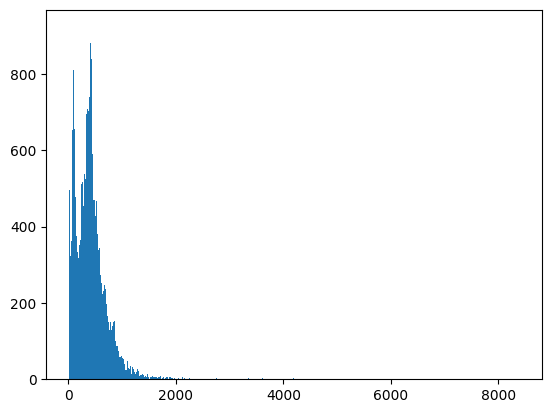

In [ ]:
plt.hist([len(x) for x in X], bins =1000)
plt.show()

In [ ]:
# Calculate lengths of each list in X
lengths = [len(x) for x in X]

# Calculate the mean
mean_length = np.max(lengths)

print("Mean of lengths:", mean_length)

Mean of lengths: 8396


In [ ]:
nos = np.array([len(x) for x in X])
len(nos[nos>1200])

972

In [ ]:
maxlen = 1200
X = pad_sequences(X, maxlen=maxlen)

In [ ]:
len(X[10])

1200

In [ ]:
X[10]

array([   0,    0,    0, ..., 5313,    1,  793], dtype=int32)

In [ ]:
vocab_size = len(tokenizer.word_index) + 1 # index starts from 0
vocab = tokenizer.word_index

# print("Vocabulary size:", vocab_size)
# print("Vocabulary:", vocab)

In [ ]:
def get_weights_matrix(model):
    # Initialize a numpy array filled with zeros to store the weights
    weight_matrix = np.zeros((vocab_size, DIM))

    # Iterate over each word in the vocabulary
    for word, i in vocab.items():
        # Retrieve the word vector from the Word2Vec model and assign it to the corresponding row in the weight matrix
        weight_matrix[i] = model.wv[word]

    # Return the weight matrix containing the word embeddings
    return weight_matrix

In [ ]:
embedding_vectors = get_weights_matrix(w2v_model) # using the individual vocab words of the the dataset to get word2vec weights assigned

In [ ]:
w2v_model.wv.most_similar('india')

[('pakistan', 0.7485405802726746),
 ('china', 0.7272327542304993),
 ('japan', 0.7159072160720825),
 ('malaysia', 0.7090864181518555),
 ('australia', 0.6727469563484192),
 ('canada', 0.6578260064125061),
 ('thailand', 0.6421573758125305),
 ('egypt', 0.6410444974899292),
 ('singapore', 0.6364646553993225),
 ('tunisia', 0.6250486373901367)]

In [ ]:
w2v_model.wv.most_similar('the')

[('a', 0.6198538541793823),
 ('this', 0.5909501314163208),
 ('itself', 0.5583556890487671),
 ('its', 0.5443121790885925),
 ('his', 0.5326060056686401),
 ('any', 0.5207731127738953),
 ('their', 0.5062087178230286),
 ('another', 0.4918377697467804),
 ('an', 0.4731055796146393),
 ('that', 0.46778109669685364)]

In [ ]:
w2v_model.wv.most_similar('the')

[('a', 0.6198538541793823),
 ('this', 0.5909501314163208),
 ('itself', 0.5583556890487671),
 ('its', 0.5443121790885925),
 ('his', 0.5326060056686401),
 ('any', 0.5207731127738953),
 ('their', 0.5062087178230286),
 ('another', 0.4918377697467804),
 ('an', 0.4731055796146393),
 ('that', 0.46778109669685364)]

In [ ]:
embedding_vectors.shape

(122716, 100)

In [ ]:
embedding_vectors

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 8.44398558e-01, -3.71493727e-01, -3.98619652e-01, ...,
        -1.43593156e+00,  3.08483541e-01, -5.51634550e-01],
       [-1.57802045e+00,  1.69730091e+00,  1.78153849e+00, ...,
         6.80643499e-01, -4.28024435e+00,  1.22288895e+00],
       ...,
       [-2.25109663e-02,  3.22119445e-02,  4.29342361e-03, ...,
         9.27863084e-03, -1.78957619e-02, -2.36453060e-02],
       [ 1.28087876e-02,  3.04679684e-02,  8.81391764e-03, ...,
         1.32970221e-04,  9.97660682e-03,  4.87953564e-03],
       [ 1.04147047e-02,  2.98929098e-03,  1.92576330e-02, ...,
         2.46624392e-03,  2.24190671e-02,  1.38417566e-02]])

In [ ]:
# Initialize a Sequential model
model = Sequential()

# Add Embedding layer with pre-trained weights
model.add(Embedding(vocab_size, output_dim=DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False))

# Add LSTM layer
model.add(LSTM(units=128))  # return_sequences=True to pass output to the next layer

# Final output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model with a different loss function
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['acc'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1200, 100)         12271600  
                                                                 
 lstm_2 (LSTM)               (None, 128)               117248    
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 12388977 (47.26 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 12271600 (46.81 MB)
_________________________________________________________________


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y)

In [ ]:
model.fit(X_train, y_train, validation_split=0.3, epochs=3)

Epoch 1/3
737/737 [==============================] - 43s 55ms/step - loss: 0.0456 - acc: 0.9446 - val_loss: 0.0495 - val_acc: 0.9412
Epoch 2/3
737/737 [==============================] - 41s 56ms/step - loss: 0.0263 - acc: 0.9685 - val_loss: 0.0246 - val_acc: 0.9697
Epoch 3/3
737/737 [==============================] - 40s 55ms/step - loss: 0.0259 - acc: 0.9671 - val_loss: 0.0224 - val_acc: 0.9730


1053/1053 [==============================] - 18s 17ms/step
Training Accuracy  0.977488714659064
Confusion Matrix
[[16957   653]
 [  105 15957]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98     17610
           1       0.96      0.99      0.98     16062

    accuracy                           0.98     33672
   macro avg       0.98      0.98      0.98     33672
weighted avg       0.98      0.98      0.98     33672



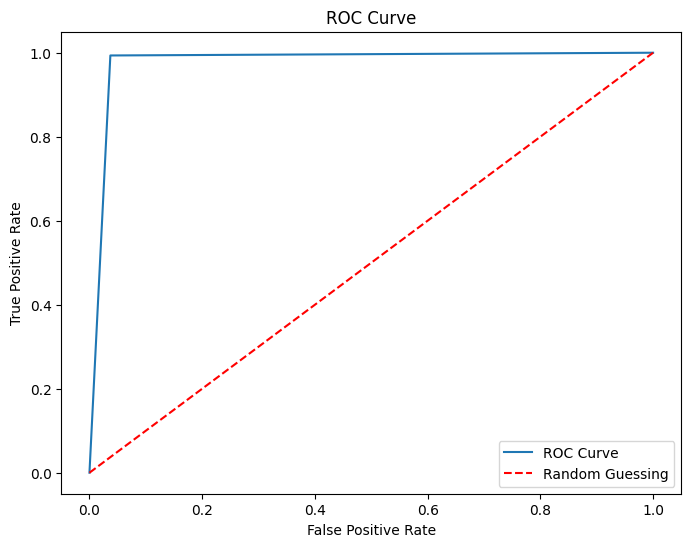

ROC AUC Score: 0.9781908138331937


In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

# Training results

# Calucating the Training accuracy
y_pred = (model.predict(X_train) >=0.5).astype(int)
train_accuracy = accuracy_score(y_train, y_pred)
print("Training Accuracy ", train_accuracy)

# Calucating the confusion matrix
confusion_mat = confusion_matrix(y_train, y_pred)
print("Confusion Matrix")
print(confusion_mat)

# Calculate recall, precision and f1 score
class_report = classification_report(y_train, y_pred)
print("Classification Report:")
print(class_report)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_train, y_pred)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Calculate AUC score
roc_auc = roc_auc_score(y_train, y_pred)
print("ROC AUC Score:", roc_auc)

351/351 [==============================] - 7s 19ms/step
testing Accuracy  0.9726503340757239
Confusion Matrix
[[5615  256]
 [  51 5303]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      5871
           1       0.95      0.99      0.97      5354

    accuracy                           0.97     11225
   macro avg       0.97      0.97      0.97     11225
weighted avg       0.97      0.97      0.97     11225



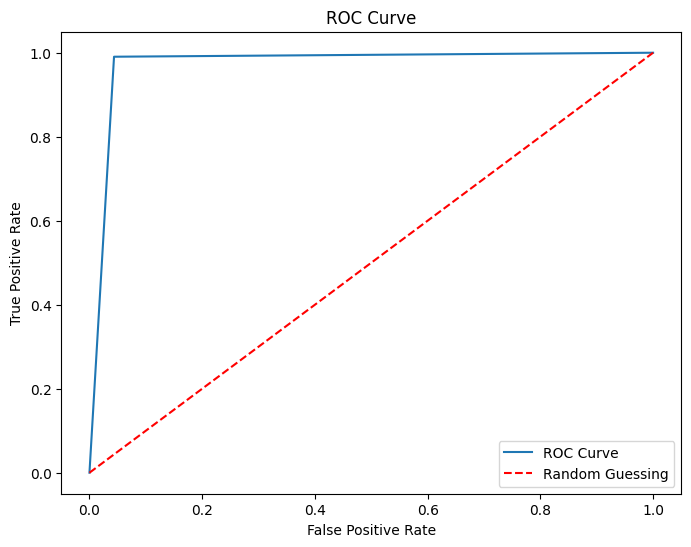

ROC AUC Score: 0.9734351278168584


In [ ]:
# testing results

# Calucating the testing accuracy
y_pred = (model.predict(X_test) >=0.5).astype(int)
test_accuracy = accuracy_score(y_test, y_pred)
print("testing Accuracy ", test_accuracy)

# Calucating the confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(confusion_mat)

# Calculate recall, precision and f1 score
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Calculate AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print("ROC AUC Score:", roc_auc)

In [ ]:
def predict_binary_labels(texts, model, tokenizer, maxlen=5000, threshold=0.5):
    # Tokenize and pad the input sequences
    x_tokenized = tokenizer.texts_to_sequences(texts)
    x_padded = pad_sequences(x_tokenized, maxlen=maxlen)

    # Predict using the model
    predictions = model.predict(x_padded)

    # Convert predictions to binary labels based on threshold
    binary_predictions = (predictions >= threshold).astype(int)

    return binary_predictions # 1 : True, 0 : False

In [ ]:
# Example usage:
x = "Election Commission orders removal of home secretaries in 6 states, Bengal DGP"
predictions = predict_binary_labels([x], model, tokenizer)
print(predictions)

1/1 [==============================] - 0s 98ms/step
[[1]]


In [ ]:
# Save the model
model.save('news_detection_lstm_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Example usage:
x = "Russia-NATO, one step away from a full-scale World War 3, Putin warns the West"
predictions = predict_binary_labels([x], model, tokenizer)
print(predictions)

1/1 [==============================] - 0s 121ms/step
[[0]]


In [ ]:
x = "The Supreme Court today directed the State Bank of India (SBI) to disclose all details related to electoral bonds that allowed individuals and companies to make donations to political parties. This must include the serial number of each bond, said a five-judge bench, headed by Chief Justice of India DY Chandrachud"
predictions = predict_binary_labels([x], model, tokenizer)
print(predictions)

1/1 [==============================] - 0s 74ms/step
[[1]]


Observations and Results :


* The model has impressive predictability, however it still needs periodic training with the latest news to enhance its capability to differentiate between real and fake news concerning current affairs.

* The model is presently trained on Twitter news and data from US news agencies such as Reuters. Despite the dataset primarily comprising US national and international news, it has successfully predicted Indian news accurately. However, to enhance its reliability further, it is recommended to train the model on regional news data to improve its performance in predicting news from specific regions.

* Training the model with futher epochs would too contibute to improve the model prediction